# FinBERT Sentiment Analysis & Economic Comparison
---
This notebook performs sentiment analysis on the Fed Master Corpus using the `ProsusAI/finbert` model and compares the resulting sentiment index with CPI and PPI economic indicators.

**Objective:**
1. Run inference using FinBERT.
2. Calculate a Net Sentiment Index: $(Hawkish - Dovish) / Total$.
3. Compare the index with Inflation Metrics (CPI, PPI).

In [1]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

# Set plot style
sns.set_style("whitegrid")
print("Libraries Loaded.")

Libraries Loaded.


## 1. Setup & Configuration

In [2]:
# Paths
DATA_DIR = '../data'
MASTER_CORPUS_PATH = os.path.join(DATA_DIR, 'master', 'fed_master_corpus.csv')
RESULTS_PATH = os.path.join(DATA_DIR, 'processed', 'finbert_inference_results.csv')
INDEX_PATH = os.path.join(DATA_DIR, 'processed', 'finbert_monthly_index.csv')
ECON_DATA_PATH = os.path.join(DATA_DIR, 'raw', 'econ_indicators.csv')

# Model
MODEL_NAME = "ProsusAI/finbert"

print(f"Reading data from: {MASTER_CORPUS_PATH}")

Reading data from: ../data\master\fed_master_corpus.csv


In [3]:
# Load Corpus
if os.path.exists(MASTER_CORPUS_PATH):
    df_corpus = pd.read_csv(MASTER_CORPUS_PATH)
    print(f"Loaded {len(df_corpus)} sentences.")
    # Ensure date is datetime
    df_corpus['date'] = pd.to_datetime(df_corpus['date'])
else:
    print(f"ERROR: File not found at {MASTER_CORPUS_PATH}")

df_corpus.head()

Loaded 7442 sentences.


,date,text,section,source,speaker,word_count,month_year
0,2018-01-31,The manager of the System Open Market Account ...,Developments in Financial Markets,Minutes,NaN,24,2018-01
1,2018-01-31,Domestic financial market conditions eased con...,Staff Review of Financial Situation,Minutes,NaN,11,2018-01
2,2018-01-31,A strengthening outlook for economic growth in...,Staff Review of Financial Situation,Minutes,NaN,23,2018-01
3,2018-01-31,"U.S. equity prices, Treasury yields, and marke...",Staff Review of Financial Situation,Minutes,NaN,31,2018-01
4,2018-01-31,"In addition, the dollar depreciated broadly am...",Staff Review of Financial Situation,Minutes,NaN,29,2018-01


## 2. Sentiment Inference (FinBERT)

In [4]:
def get_sentiment_label(finbert_label):
    """
    Map FinBERT labels to Fed Context:
    Negative -> Hawkish
    Positive -> Dovish
    Neutral -> Neutral
    """
    label = str(finbert_label).lower()
    if label == 'negative':
        return 'Hawkish'
    elif label == 'positive':
        return 'Dovish'
    return 'Neutral'

def run_finbert_inference(df):
    print(f"Loading Model: {MODEL_NAME}...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
    
    device = 0 if torch.cuda.is_available() else -1
    nlp = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device, framework="pt")
    
    sentences = df['text'].astype(str).tolist()
    batch_size = 32
    predictions = []
    
    print("Starting Inference...")
    for i in tqdm(range(0, len(sentences), batch_size)):
        batch = sentences[i:i + batch_size]
        try:
            # Truncation is handled by the tokenizer args in pipeline by default for some versions, 
            # but explicit truncation ensures stability.
            preds = nlp(batch, truncation=True, max_length=512)
            predictions.extend(preds)
        except Exception as e:
            print(f"Error batch {i}: {e}")
            predictions.extend([{'label': 'neutral', 'score': 0.0}] * len(batch))
            
    # Map results
    df_res = df.copy()
    
    # Safety check on length
    if len(predictions) != len(df_res):
        print(f"Warning: Prediction count {len(predictions)} != Row count {len(df_res)}. Truncating/Aligning.")
        df_res = df_res.iloc[:len(predictions)]
        
    df_res['finbert_label'] = [p['label'] for p in predictions]
    df_res['finbert_score'] = [p['score'] for p in predictions]
    df_res['sentiment'] = df_res['finbert_label'].apply(get_sentiment_label)
    
    return df_res

In [5]:
# Execute Inference
if 'df_corpus' in locals() and not df_corpus.empty:
    df_results = run_finbert_inference(df_corpus)
    
    # Save results
    df_results.to_csv(RESULTS_PATH, index=False)
    print(f"Saved inference results to {RESULTS_PATH}")
    
    print(df_results['sentiment'].value_counts())
else:
    print("Skipping inference (no data).")

Loading Model: ProsusAI/finbert...


Device set to use cpu


Starting Inference...


100%|██████████| 233/233 [05:55<00:00,  1.53s/it]

Saved inference results to ../data\processed\finbert_inference_results.csv
sentiment
Neutral    3721
Hawkish    1893
Dovish     1828
Name: count, dtype: int64


## 3. Calculate Sentiment Index

Saved monthly index to ../data\processed\finbert_monthly_index.csv


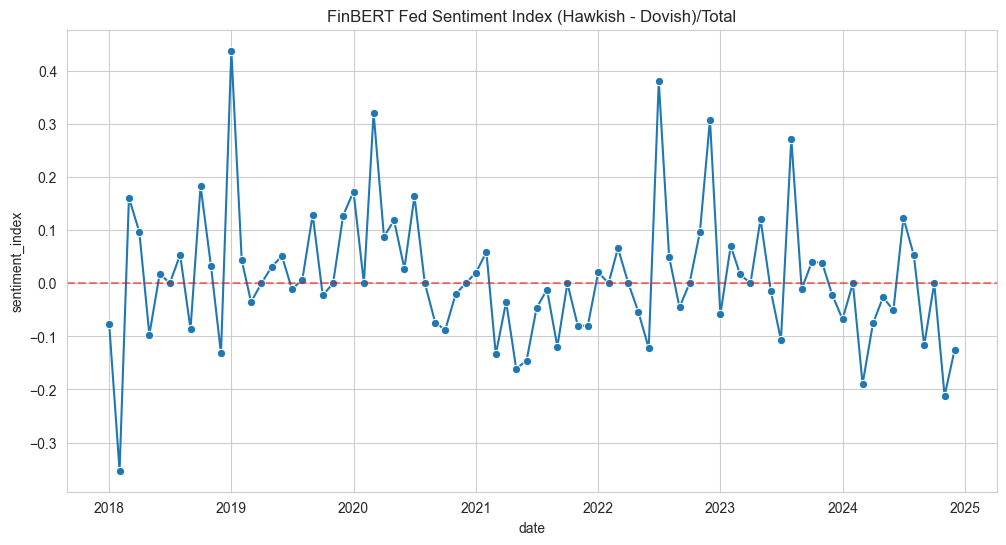

In [6]:
def calculate_net_sentiment(group):
    counts = group['sentiment'].value_counts()
    h = counts.get('Hawkish', 0)
    d = counts.get('Dovish', 0)
    n = counts.get('Neutral', 0)
    total = h + d + n
    if total == 0: return 0
    # (Hawkish - Dovish) / Total
    return (h - d) / total

if 'df_results' in locals():
    # Resample by month start
    df_monthly = df_results.set_index('date').resample('MS').apply(calculate_net_sentiment).reset_index(name='sentiment_index')
    
    # Save Index
    df_monthly.to_csv(INDEX_PATH, index=False)
    print(f"Saved monthly index to {INDEX_PATH}")
    
    # Plot Sentiment Index
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_monthly, x='date', y='sentiment_index', marker='o')
    plt.title('FinBERT Fed Sentiment Index (Hawkish - Dovish)/Total')
    plt.axhline(0, color='red', linestyle='--', alpha=0.5)
    plt.show()

## 4. Compare with Economic Indicators

In [7]:
# Load Economic Data
if os.path.exists(ECON_DATA_PATH):
    df_econ = pd.read_csv(ECON_DATA_PATH)
    df_econ['DATE'] = pd.to_datetime(df_econ['DATE'])
    
    # Filter since 2018 to match our corpus
    df_econ = df_econ[df_econ['DATE'] >= '2018-01-01']
    
    print("Economic Data Loaded:")
    print(df_econ.head())
else:
    print("Economic data file not found.")
    df_econ = pd.DataFrame()

Economic Data Loaded:
        DATE      CPI    PPI  CPI_YoY  PPI_YoY
0 2018-02-01  249.529  199.3      NaN      NaN
1 2018-03-01  249.577  199.3      NaN      NaN
2 2018-04-01  250.227  200.3      NaN      NaN
3 2018-05-01  250.792  203.2      NaN      NaN
4 2018-06-01  251.018  204.2      NaN      NaN


Merged Data Points: 83


,date,sentiment_index,DATE,CPI,PPI,CPI_YoY,PPI_YoY
0,2018-02-01,-0.352941,2018-02-01,249.529,199.3,NaN,NaN
1,2018-03-01,0.160714,2018-03-01,249.577,199.3,NaN,NaN
2,2018-04-01,0.096552,2018-04-01,250.227,200.3,NaN,NaN
3,2018-05-01,-0.096618,2018-05-01,250.792,203.2,NaN,NaN
4,2018-06-01,0.018018,2018-06-01,251.018,204.2,NaN,NaN


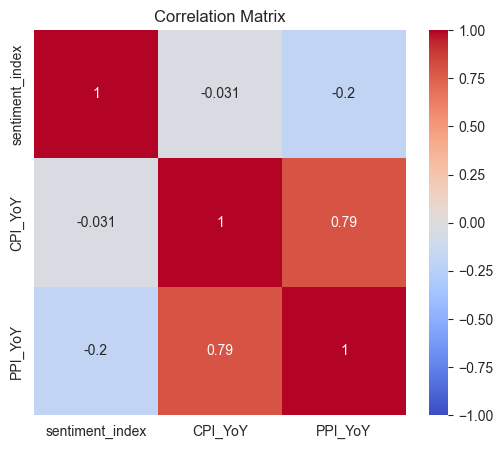

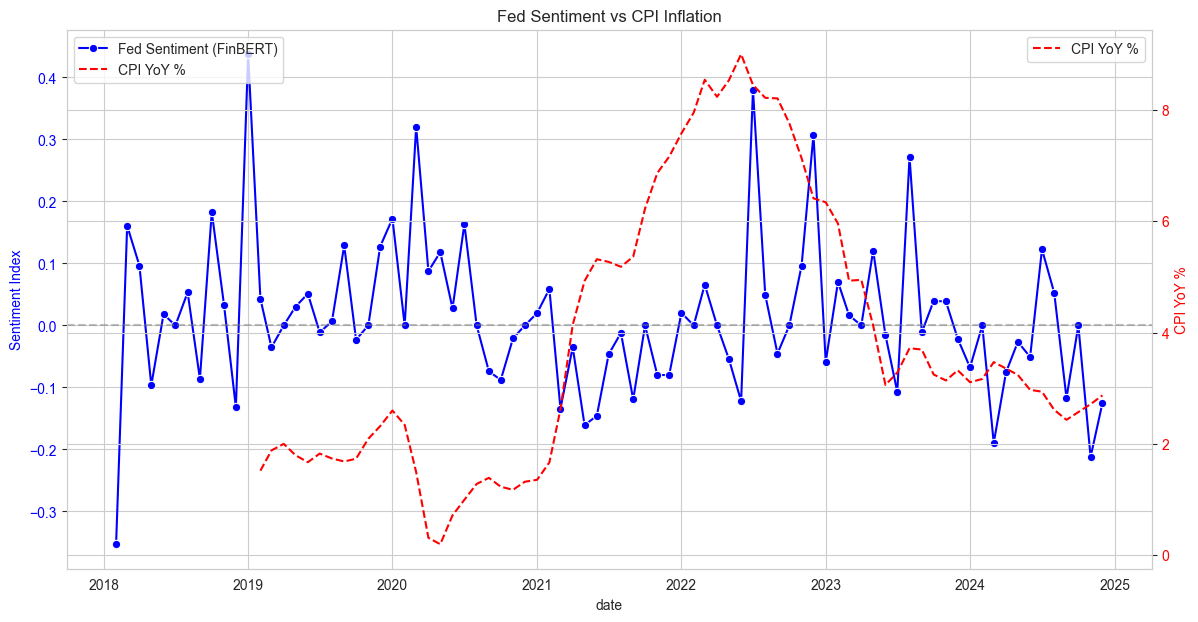

In [8]:
# Merge Data
if 'df_monthly' in locals() and not df_econ.empty:
    # Merge on Date (assuming monthly alignment)
    # Use 'inner' or 'left' depending on preference. Left keeps sentiment dates.
    df_merged = pd.merge(df_monthly, df_econ, left_on='date', right_on='DATE', how='inner')
    
    print(f"Merged Data Points: {len(df_merged)}")
    display(df_merged.head())
    
    # Correlation
    corr_cols = ['sentiment_index', 'CPI_YoY', 'PPI_YoY']
    corr_matrix = df_merged[corr_cols].corr()
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix')
    plt.show()
    
    # Dual Axis Plot: Sentiment vs CPI
    fig, ax1 = plt.subplots(figsize=(14, 7))

    sns.lineplot(data=df_merged, x='date', y='sentiment_index', ax=ax1, color='blue', label='Fed Sentiment (FinBERT)', marker='o')
    ax1.set_ylabel('Sentiment Index', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)

    ax2 = ax1.twinx()
    sns.lineplot(data=df_merged, x='date', y='CPI_YoY', ax=ax2, color='red', label='CPI YoY %', linestyle='--')
    ax2.set_ylabel('CPI YoY %', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title('Fed Sentiment vs CPI Inflation')
    
    # Combine legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
    
    plt.show()

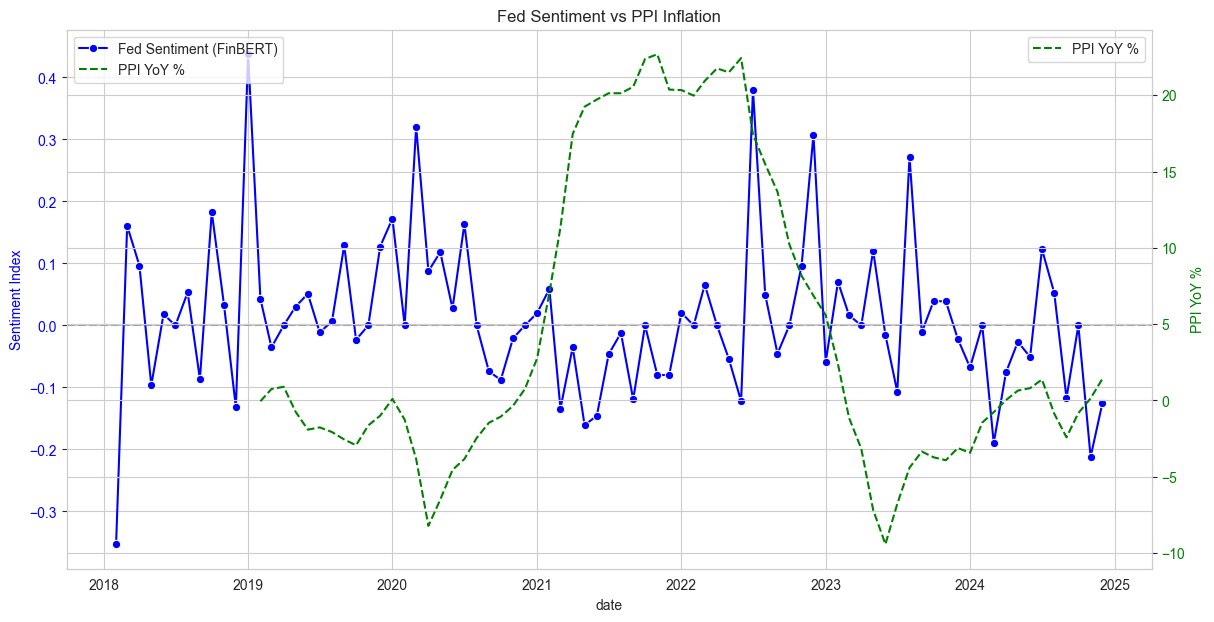

In [9]:
# Dual Axis Plot: Sentiment vs PPI
if 'df_merged' in locals() and not df_merged.empty:
    fig, ax1 = plt.subplots(figsize=(14, 7))

    sns.lineplot(data=df_merged, x='date', y='sentiment_index', ax=ax1, color='blue', label='Fed Sentiment (FinBERT)', marker='o')
    ax1.set_ylabel('Sentiment Index', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)

    ax2 = ax1.twinx()
    sns.lineplot(data=df_merged, x='date', y='PPI_YoY', ax=ax2, color='green', label='PPI YoY %', linestyle='--')
    ax2.set_ylabel('PPI YoY %', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    plt.title('Fed Sentiment vs PPI Inflation')
    
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
    
    plt.show()